# Make supplementary data files
This Python Jupyter notebook makes supplementary files for antibody sets for which doing this is specified in `escape_profiles_config`:
 - raw data files
 - [dms-view](https://dms-view.github.io/) input files
 - correlations between libraries

## Set up
Import Python modules:

In [1]:
import itertools
import math
import os

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import pandas as pd

from plotnine import *

import yaml

Read the configuration file:

In [2]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Create output directory:

In [3]:
os.makedirs(config['supp_data_dir'], exist_ok=True)

Extract from configuration what we will use as the site- and mutation-level metrics:

In [4]:
site_metric = config['site_metric']
mut_metric = config['mut_metric']

print(f"At site level, quantifying selection by {site_metric}")
print(f"At mutation level, quantify selection by {mut_metric}")

At site level, quantifying selection by site_total_escape_frac_epistasis_model
At mutation level, quantify selection by mut_escape_frac_epistasis_model


Read escape profiles configuration and get sets for which we will be making supp data:

In [5]:
with open (config['escape_profiles_config']) as f:
    escape_profiles_config = yaml.safe_load(f)
    
condition_sets = {name: specs['conditions'] for name, specs in escape_profiles_config.items()
                  if 'make_supp_data' in specs and specs['make_supp_data']}

print('Making supplementary data for the following condition sets:\n  ' + '\n  '.join(condition_sets))

Making supplementary data for the following condition sets:
  Linfa-NUS_antibodies
  Linfa-NUS_antibodies_set1
  Linfa-NUS_antibodies_set2
  Linfa-NUS_antibodies_set3


Read the escape fractions

In [6]:
print(f"Reading escape fractions from {config['escape_fracs']}")
escape_fracs_all = pd.read_csv(config['escape_fracs'])

Reading escape fractions from results/escape_scores/escape_fracs.csv


Read the configuration about what data gets output on what PDBs:

In [7]:
with open (config['output_pdbs_config']) as f:
    output_pdbs_config = yaml.safe_load(f)

## Correlations between libraries
Plot correlations between libraries for mutation- and site-level escape:


Plotting correlations of mutation escape for Linfa-NUS_antibodies


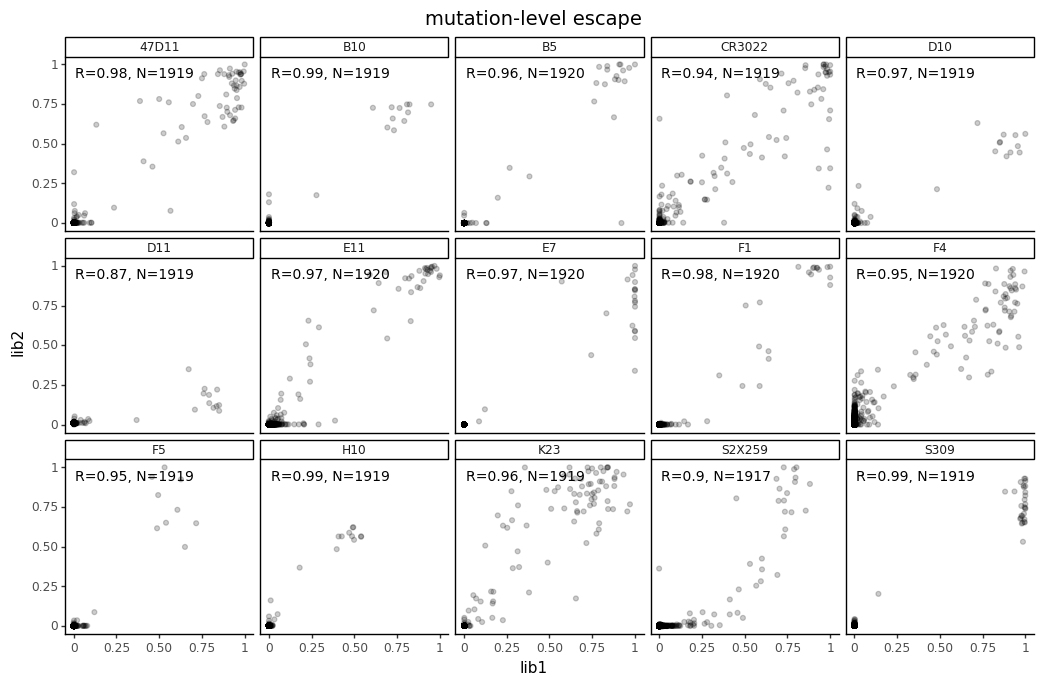

Saving plot to results/supp_data/Linfa-NUS_antibodies-mutation-corr.pdf

Plotting correlations of mutation escape for Linfa-NUS_antibodies_set1


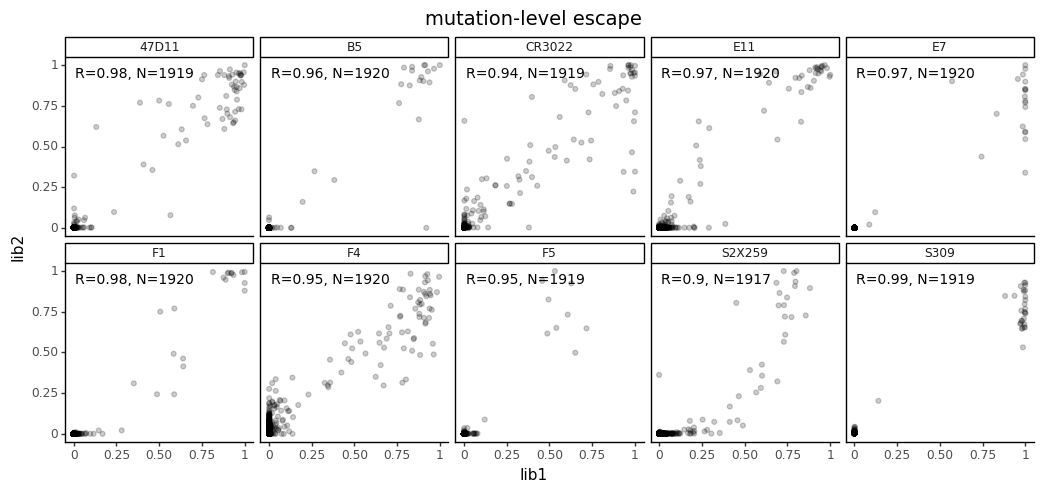

Saving plot to results/supp_data/Linfa-NUS_antibodies_set1-mutation-corr.pdf

Plotting correlations of mutation escape for Linfa-NUS_antibodies_set2


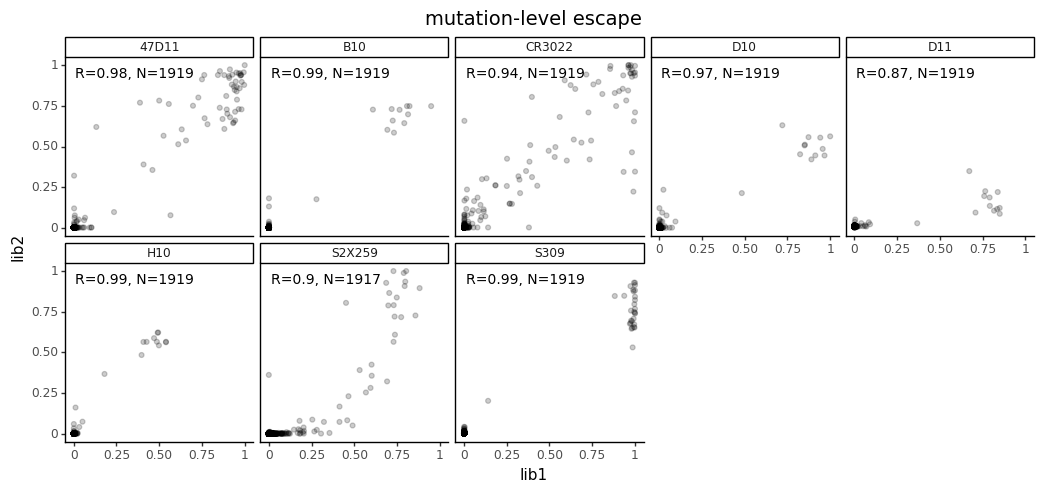

Saving plot to results/supp_data/Linfa-NUS_antibodies_set2-mutation-corr.pdf

Plotting correlations of mutation escape for Linfa-NUS_antibodies_set3


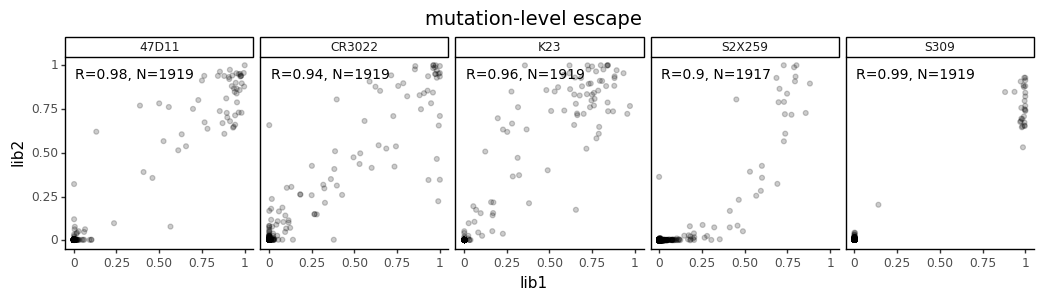

Saving plot to results/supp_data/Linfa-NUS_antibodies_set3-mutation-corr.pdf

Plotting correlations of site escape for Linfa-NUS_antibodies


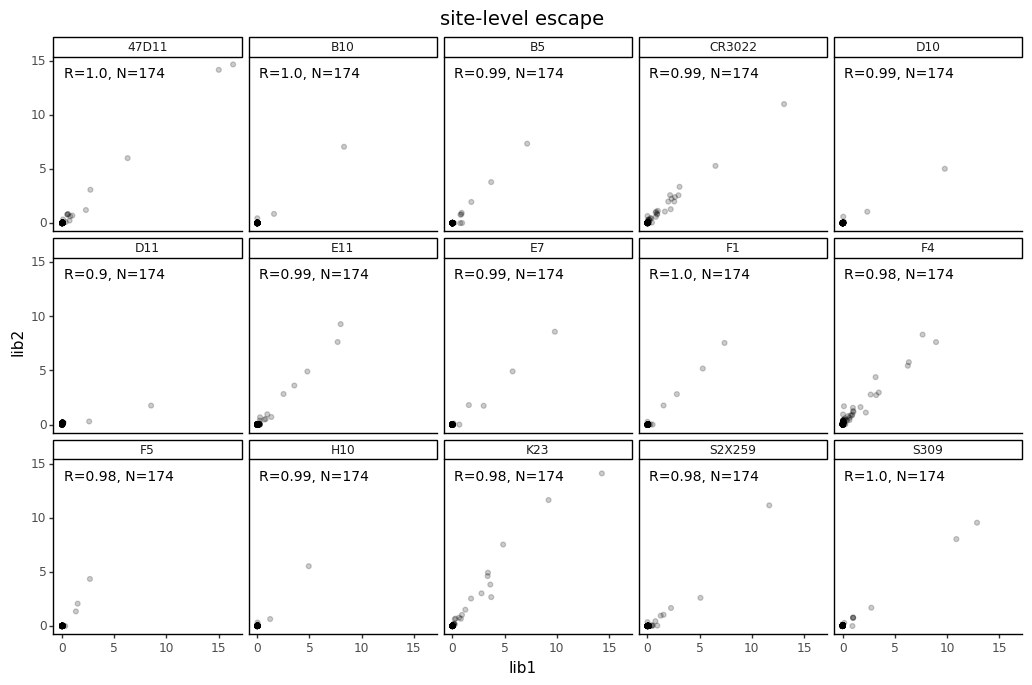

Saving plot to results/supp_data/Linfa-NUS_antibodies-site-corr.pdf

Plotting correlations of site escape for Linfa-NUS_antibodies_set1


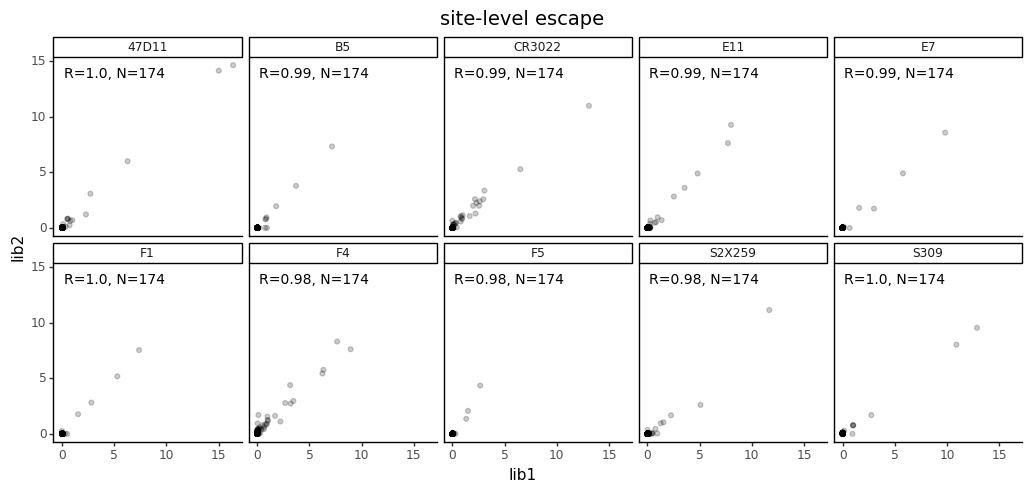

Saving plot to results/supp_data/Linfa-NUS_antibodies_set1-site-corr.pdf

Plotting correlations of site escape for Linfa-NUS_antibodies_set2


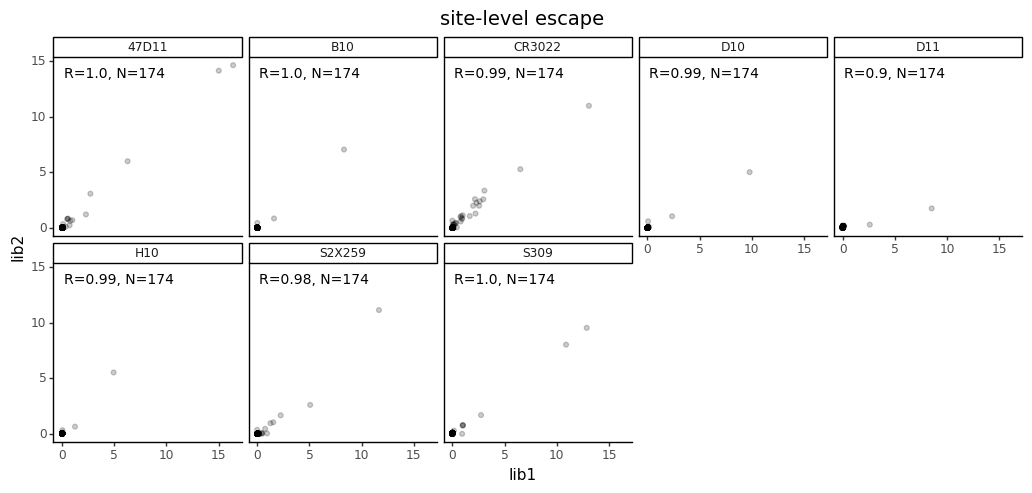

Saving plot to results/supp_data/Linfa-NUS_antibodies_set2-site-corr.pdf

Plotting correlations of site escape for Linfa-NUS_antibodies_set3


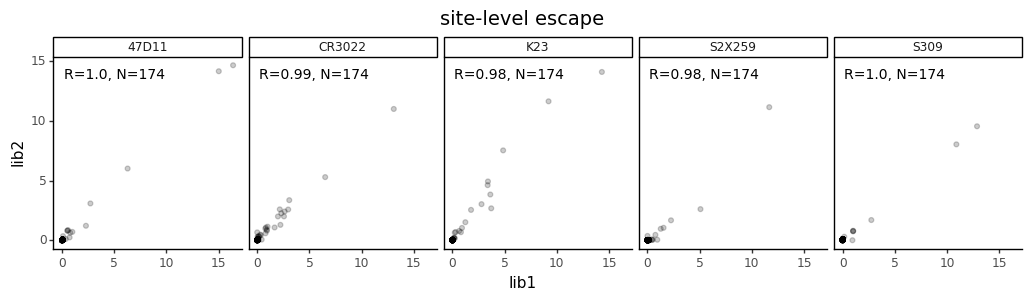

Saving plot to results/supp_data/Linfa-NUS_antibodies_set3-site-corr.pdf


In [8]:
libraries = [lib for lib in escape_fracs_all['library'].unique() if lib != "average"]
assert len(libraries) == 2, 'plot only makes sense if 2 libraries'

for metric_type, (set_name, condition_set) in itertools.product(['mutation', 'site'],
                                                                condition_sets.items()):
    
    print(f"\nPlotting correlations of {metric_type} escape for {set_name}")
    
    if metric_type == 'mutation':
        metric = mut_metric
        pivot_index = ['selection', 'site', 'mutation']
    elif metric_type == 'site':
        metric = site_metric
        pivot_index = ['selection', 'site']
    else:
        raise ValueError(f"invalid `metric_type` {metric_type}")

    # wide data frame with each library's score in a different column
    df_wide = (
        escape_fracs_all
        .query('library != "average"')
        .query('selection in @condition_set')
        .assign(selection=lambda x: x['selection'].map(condition_set))
        # need to drop duplicate columns if using site metric
        [['library', metric] + pivot_index]
        .drop_duplicates()
        # now make columns for each library, only keep mutants with scores for both libs
        .pivot_table(index=pivot_index,
                     columns='library',
                     values=metric)
        .reset_index()
        .dropna(axis=0)
        )

    # correlations between libraries
    corrs = (
        df_wide
        .groupby('selection')
        [libraries]
        .corr(method='pearson')
        .reset_index()
        .query('library == @libraries[0]')
        .assign(correlation=lambda x: 'R=' + x[libraries[1]].round(2).astype(str))
        [['selection', 'correlation']]
        # add number of mutations measured
        .merge(df_wide
               .groupby('selection')
               .size()
               .rename('n')
               .reset_index()
               )
        .assign(correlation=lambda x: x['correlation'] + ', N=' + x['n'].astype(str))
        )

    # plot correlations
    nfacets = df_wide['selection'].nunique()
    ncol = min(nfacets, 5)
    nrow = math.ceil(nfacets / ncol)
    xmin = df_wide[libraries[0]].min()
    xspan = df_wide[libraries[0]].max() - xmin
    ymin = df_wide[libraries[1]].min()
    yspan = df_wide[libraries[1]].max() - ymin
    p = (ggplot(df_wide) +
         aes(libraries[0], libraries[1]) +
         geom_point(alpha=0.2, color='black') +
         geom_text(mapping=aes(label='correlation'),
                   data=corrs,
                   x=0.01 * xspan + xmin,
                   y=0.99 * yspan + ymin,
                   size=10,
                   ha='left',
                   va='top',
                   ) +
         facet_wrap('~ selection', ncol=ncol) +
         theme_classic() +
         theme(figure_size=(2.5 * ncol, 2.5 * nrow),
               plot_title=element_text(size=14)) +
         ggtitle(f"{metric_type}-level escape")
         )

    fig = p.draw()
    display(fig)
    plotfile = os.path.join(config['supp_data_dir'],
                            f"{set_name}-{metric_type}-corr.pdf")
    print(f"Saving plot to {plotfile}")
    p.save(plotfile, verbose=False)
    plt.close(fig)

## Raw data files
Get the "raw data" for the effects of each mutation on antibody escape.
This has just the columns of most interest for the average of the two libraries, renamed in a sensible way:

In [9]:
raw_data = (
    escape_fracs_all
    .query('library == "average"')
    .drop(columns=['library'])
    .rename(columns={mut_metric: 'mut_escape',
                     site_metric: 'site_total_escape'})
    [['condition', 'site', 'label_site', 'wildtype', 'mutation', 'protein_chain',
      'protein_site', 'mut_escape', 'site_total_escape']]
    .assign(site_max_escape=lambda x: x.groupby(['condition', 'site'])['mut_escape'].transform('max'))
    )

Now write the raw data for each condition set:

In [10]:
for set_name, condition_set in condition_sets.items():
    print(f"\nRaw data for {set_name}:")
    df = (raw_data
          .query('condition in @condition_set')
          .assign(condition=lambda x: x['condition'].map(condition_set))
          [['condition', 'label_site', 'wildtype', 'mutation', 'mut_escape',
            'site_total_escape', 'site_max_escape']]
          .rename(columns={'label_site': 'site'})
          )
    #display(HTML(df.head().to_html(index=False)))
    csv_file = os.path.join(config['supp_data_dir'], f"{set_name}_raw_data.csv")
    print(f"Writing to {csv_file}")
    df.to_csv(csv_file, index=False, float_format='%.4g')


Raw data for Linfa-NUS_antibodies:
Writing to results/supp_data/Linfa-NUS_antibodies_raw_data.csv

Raw data for Linfa-NUS_antibodies_set1:
Writing to results/supp_data/Linfa-NUS_antibodies_set1_raw_data.csv

Raw data for Linfa-NUS_antibodies_set2:
Writing to results/supp_data/Linfa-NUS_antibodies_set2_raw_data.csv

Raw data for Linfa-NUS_antibodies_set3:
Writing to results/supp_data/Linfa-NUS_antibodies_set3_raw_data.csv


## Data for `dms-view`:
Now we write the data in a format for display by [dms-view](https://dms-view.github.io/docs/dataupload) with several different possible mutation-level escape color schemes and also allowing options to visualize directly the deep mutational scanning data.
We write such a file for each condition set for the PDBs specified in `output_pdbs_config`.

First, create the different color schemes for the mutation-level escape.
The first step is to read these color schemes:

In [11]:
print(f"Reading DMS color schemes from {config['escape_profiles_dms_colors']}")

dms_colors = (
    pd.read_csv(config['escape_profiles_dms_colors'])
    .drop(columns=['bind', 'expr'])
    .rename(columns={'site': 'label_site'})
    .rename(columns={'bind_color': 'color ACE2 bind',
                     'expr_color': 'color RBD expr'})
    # add color schemes by functional group and all gray
    .assign(**{'color gray': '#696969',
               'color func group': 'functional'})
    )

Reading DMS color schemes from results/escape_profiles/escape_profiles_dms_colors.csv


Now write a [dms-view](https://dms-view.github.io/docs/dataupload) input file that allows different mutation-level coloring schemes:

In [12]:
dms_view_df = (
    pd.concat([raw_data.merge(dms_colors[['label_site', 'mutation', color]],
                              how='left',
                              validate='many_to_one')
                       .rename(columns={color: 'color_for_mutation',
                                        'mut_escape': 'mut_escape ' + color})
               for color in dms_colors.drop(columns=['label_site', 'mutation']).columns.tolist()
               ])
    .rename(columns={'site_max_escape': 'site_max escape',
                     'site_total_escape': 'site_total escape'})
    .drop(columns='protein_chain')
    )

display(HTML(dms_view_df.head().to_html(index=False)))

condition,site,label_site,wildtype,mutation,protein_site,mut_escape color ACE2 bind,site_total escape,site_max escape,color_for_mutation,mut_escape color RBD expr,mut_escape color gray,mut_escape color func group
S2X259_59,1,331,N,A,331,0.000317,0.04006,0.02523,#692505,NaN,NaN,NaN
S2X259_59,1,331,N,D,331,0.000000,0.04006,0.02523,#662505,NaN,NaN,NaN
S2X259_59,1,331,N,E,331,0.000062,0.04006,0.02523,#662505,NaN,NaN,NaN
S2X259_59,1,331,N,F,331,0.001883,0.04006,0.02523,#722805,NaN,NaN,NaN
S2X259_59,1,331,N,G,331,0.025230,0.04006,0.02523,#6a2605,NaN,NaN,NaN


Finally, write `dms-view` input files for each condition set:

In [13]:
for set_name, condition_set in condition_sets.items():
    
    for pdb_name, pdb_specs in output_pdbs_config.items():
        
        # get all conditions for this set to be written to this PDB
        if isinstance(pdb_specs['conditions'], str) and pdb_specs['conditions'].upper() == 'ALL':
            pdb_conditions = condition_set
        else:
            assert isinstance(pdb_specs['conditions'], list)
            pdb_conditions = [condition for condition in condition_set
                              if condition in pdb_specs['conditions']]
        if not pdb_conditions:
            continue
            
        df = (dms_view_df
              .query('condition in @pdb_conditions')
              .assign(condition=lambda x: x['condition'].map(condition_set))  # re-name to shorter names
              )
        
        # assign all relevant protein chains
        cols = df.columns.tolist()
        i = cols.index('protein_site')  # add protein chain column here
        newcols = cols[: i] + ['protein_chain'] + cols[i: ]
        chains = ' '.join(pdb_specs['chains'])
        df = df.assign(protein_chain=chains)[newcols]
   
        csv_file = os.path.join(config['supp_data_dir'], f"{set_name}_{pdb_name}_dms-view_data.csv")
        print(f"Writing `dms-view` input file for {set_name} mapped to PDB {pdb_name} to {csv_file}")
        df.to_csv(csv_file, index=False, float_format='%.4g')

Writing `dms-view` input file for Linfa-NUS_antibodies mapped to PDB 6m0j to results/supp_data/Linfa-NUS_antibodies_6m0j_dms-view_data.csv
Writing `dms-view` input file for Linfa-NUS_antibodies_set1 mapped to PDB 6m0j to results/supp_data/Linfa-NUS_antibodies_set1_6m0j_dms-view_data.csv
Writing `dms-view` input file for Linfa-NUS_antibodies_set2 mapped to PDB 6m0j to results/supp_data/Linfa-NUS_antibodies_set2_6m0j_dms-view_data.csv
Writing `dms-view` input file for Linfa-NUS_antibodies_set3 mapped to PDB 6m0j to results/supp_data/Linfa-NUS_antibodies_set3_6m0j_dms-view_data.csv
